# Declare libraries

In [1]:
from osgeo import gdal
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import read_cover_fraction as rcf

# Declare functions

## function to read the data

In [2]:
def get_dataSG(fname,latmax,latmin,lonmax,lonmin):

    gdal.UseExceptions()
    ds = gdal.Open(fname)
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #
    #
    #
    xres = gt[1]
    yres = gt[5]
    #
    xmin = gt[0]
    ymin = gt[3]
    #
    xmax = gt[0] + (xres * ds.RasterXSize)
    ymax = gt[3] + (yres * ds.RasterYSize)
#    else:
#        xmax = gt[0] + (xres * ds.RasterXSize) 
#        ymax = gt[3] + (yres * ds.RasterYSize) 


    X=np.arange(xmin+xres,xmax+xres,xres)
    Y=np.arange(ymin+yres,ymax+yres,yres)


    #Chunck the data to save RAM for plotting
    #Ydecreasing
    b=np.min(np.where(Y<latmin)[0])
    a=np.max(np.where(Y>latmax)[0])

    c=np.max(np.where(X<lonmin)[0])
    d=np.min(np.where(X>lonmax)[0])

#    print(np.max(data))
#    print(np.min(data))
    #ECOCLIMAP data have no projections so no need to reproject the data
    #to be verified for other datasets
    LAT=Y[a:b]
    LON=X[c:d]
    D=data[a:b,c:d]

    return (LAT,LON,D)

## Read station coordinates function

In [3]:
def readstationcoordinate(fnstation):
    data=open(fnstation,'r')
    lat=[]
    lon=[]
    for d in data:
        lat.append(d.split(' ')[0].strip(' '))
        lon.append(d.split(' ')[1].strip(' '))
    LAT=np.array(lat).astype(float)
    LON=np.array(lon).astype(float)
    return(LAT,LON)

## Function to set correspondance between station and line in the csv files

In [4]:
def set_covernumber_station(LAT,LON,LATSG,LONSG,covernum,DSG):
    Linenum=[]
    for x,_ in enumerate(LAT):
        idx=np.argmin(np.abs(LAT[x]-LATSG))
        idy=np.argmin(np.abs(LON[x]-LONSG))
        Linenum.append(np.where(covernum==int(DSG[idx,idy]))[0][0])
    return (Linenum)

## Write cover station text file

In [5]:
def write_txt_file_cover_station(fntxt,LAT,LON,Linenum,covernum,covername,cityfrac,vegfrac,inwaterfrac,seafrac):
    data=open(fntxt,'w')
    data.write('LAT, LON, Covernum, Covername, City fraction, Vegetation fraction, Inland water fraction, sea fraction\n')
    for x,_ in enumerate(LAT):
        data.write(str(LAT[x])+', '+str(LON[x])+', '+str(covernum[Linenum[x]])+', '+covername[Linenum[x]]+', '+
                   str(cityfrac[Linenum[x]])+', '+str(vegfrac[Linenum[x]])+', '+
                   str(inwaterfrac[Linenum[x]])+', '+str(seafrac[Linenum[x]])+'\n')
    data.close()
    return

# MAIN 

## read station coordinate

In [6]:
fnstation='/mnt/g/Stations_list.txt'
LAT,LON=readstationcoordinate(fnstation)

## Open ECOCLIMAP-SG data

In [7]:
latmax=55.5
latmin=50.9
lonmax=-5.4
lonmin=-11

fnameSG='/mnt/g/ECOCLIMAP/ECOCLIMAPSG/test_ecosg.tif'
(LATSG,LONSG,DSG)=get_dataSG(fnameSG,latmax,latmin,lonmax,lonmin)
covernamef='/mnt/g/ECOCLIMAP/ECOCLIMAPSG/ECOCLIMAP_SG_cover_data.csv'
#get the cover deatils from the csvfile
(fieldnames,covernum,covername,cityfrac,vegfrac,inwaterfrac,seafrac)=rcf.cover_fraction(covernamef)

## Open ECOCLIMAP II data

In [8]:
latmax=55.5
latmin=50.9
lonmax=-5.4
lonmin=-11

fnameII='/mnt/g/ECOCLIMAP/open_ECOCLIMAP2.3/ECOCLIMAP_II_EUROP_V2.3.dir'
(LATII,LONII,DII)=get_dataSG(fnameII,latmax,latmin,lonmax,lonmin)
filenamecoverII='/mnt/g/ECOCLIMAP/ECOCLIMAP_II_cover_data.csv'
(fieldnamesII,covernumII,covernameII,cityfracII,vegfracII,inwaterfracII,seafracII)=rcf.cover_fraction(filenamecoverII)

## Write ECOCLIMAP-SG station details

In [9]:
Linenum=set_covernumber_station(LAT,LON,LATSG,LONSG,covernum,DSG)
fneco='/mnt/g/ECOCLIMAP/ECOCLIMAPSG_Stations_list.txt'
write_txt_file_cover_station(fneco,LAT,LON,Linenum,covernum,covername,cityfrac,vegfrac,inwaterfrac,seafrac)

## Write ECOCLIMAP II station details

In [10]:
LinenumII=set_covernumber_station(LAT,LON,LATII,LONII,covernumII,DII)
fnII='/mnt/g/ECOCLIMAP/ECOCLIMAPII_Stations_list.txt'
write_txt_file_cover_station(fnII,LAT,LON,LinenumII,covernumII,covernameII,cityfracII,vegfracII,inwaterfracII,seafracII)

# Create ECOCLIMAP-SG colormap

In [11]:
a0=(0/255.0,0/255.0,0/255.0,255/255.0)## 0 value
a=(0/255.0,0/255.0,128/255.0,255/255.0)##navy blue 1.sea    
b=(0/255.0,0/255.0,205/255.0,255/255.0)## mediumblue 2.inland waters
c=(0/255.0, 0/255.0, 255/255.0, 255/255.0) ##Blue 3.rivers
d=(211/255.0,211/255.0,211/255.0,255/255.0)## lightgray 4.Bare land
e=(169/255.0,169/255.0,169/255.0,255/255.0)## darkgray 5.Rocks
f=(255/255.0,250/255.0,250/255.0,255/255.0) ## Snow 6.permanent snow
g=(240/255.0,255/255.0,240/255.0,255/255.0)## Honeydew 7.boreal broadleaf deciduous
h=(85/255.0,107/255.0,47/255.0,255/255.0)## darkolivegreen 8.temperate broadleaf deciduous
ii=(154/255.0,205/255.0,50/255.0,255/255.0)## yellowgreen 9.tropical broadleaf deciduous
k=(0/255.0,128/255.0,0/255.0,255/255.0)## green 10.temperate broadleaf evergreen
l=(255/255.0,127/255.0,80/255.0,255/255.0)## coral 11. tropical broadleaf evergreen
m=(160/255.0,82/255.0,45/255.0,255/255.0)## siena 12. boreal needleaf evergreen
n=(34/255.0,139/255.0,34/255.0,255/255.0)## forest green 13.temperate needleleaf evergreen
o= (188/255.0,143/255.0,143/255.0,255/255.0)## rosybrown 14. boreal needleleaf deciduous
p=(205/255.0,133/255.0,63/255.0,255/255.0)## peru 15. shrubs
q=(222/255.0,184/255.0,135/255.0,255/255.0)##  burlywood 16. boreal grassland
r=(50/255.0,205/255.0,50/255.0,255/255.0)##limegreen 17 . temperate grassland
s=(255/255.0,215/255.0,0/255.0,255/255.0) ##gold 18. tropical grassland
t=(32/255.0,178/255.0,170/255.0,255/255.0)##lightseagreen 19.winter crop
u=(173/255.0,255/255.0,47/255.0,255/255.0)##green yellow 20.summer crop
v=(189/255.0,183/255.0,107/255.0,255/255.0)##darkkhaki 21. C4 crops
w=(102/255.0,102/255.0,0/255.0,255/255.0)## Dark yellow3 22.flooded trees
x=(46/255.0,139/255.0,87/255.0,255/255.0)## seagreen 23.flooded grassland
y=(255/255.0,0/255.0,0/255.0,255/255.0)## 24. red LCZ1
z=(255/255.0,30/255.0,0/255.0,255/255.0)## 25. red LCZ2
a1=(255/255.0,60/255.0,0/255.0,255/255.0)## 26. red LCZ3
b1=(255/255.0,90/255.0,0/255.0,255/255.0)## 27. red LCZ4
c1=(255/255.0,120/255.0,0/255.0,255/255.0)## 28. red LCZ5
d1=(255/255.0,150/255.0,0/255.0,255/255.0)## 29. red LCZ6
e1=(255/255.0,180/255.0,0/255.0,255/255.0)## 30. red LCZ7
f1=(255/255.0,210/255.0,0/255.0,255/255.0)## 31.red LCZ8
g1=(255/255.0,240/255.0,0/255.0,255/255.0)## 32. red LCZ9
h1=(128/255.0,128/255.0,128/255.0,255/255.0)## 33. gray LCZ10

In [12]:
scheme=[a0,a,b,c,d,e,f,g,h,ii,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,a1,b1,c1,d1,e1,f1,g1,h1]
col = ListedColormap(scheme)
uSG=np.unique(DSG)
uniqnames=[]
schemeSG=[]
for u in uSG:
    if u==0:
        uniqnames.append('no data')
        schemeSG.append(scheme[0])
    else:
        indname=np.where(u==covernum)[0][0]
        uniqnames.append(covername[indname])
        schemeSG.append(scheme[indname])

# Plot data

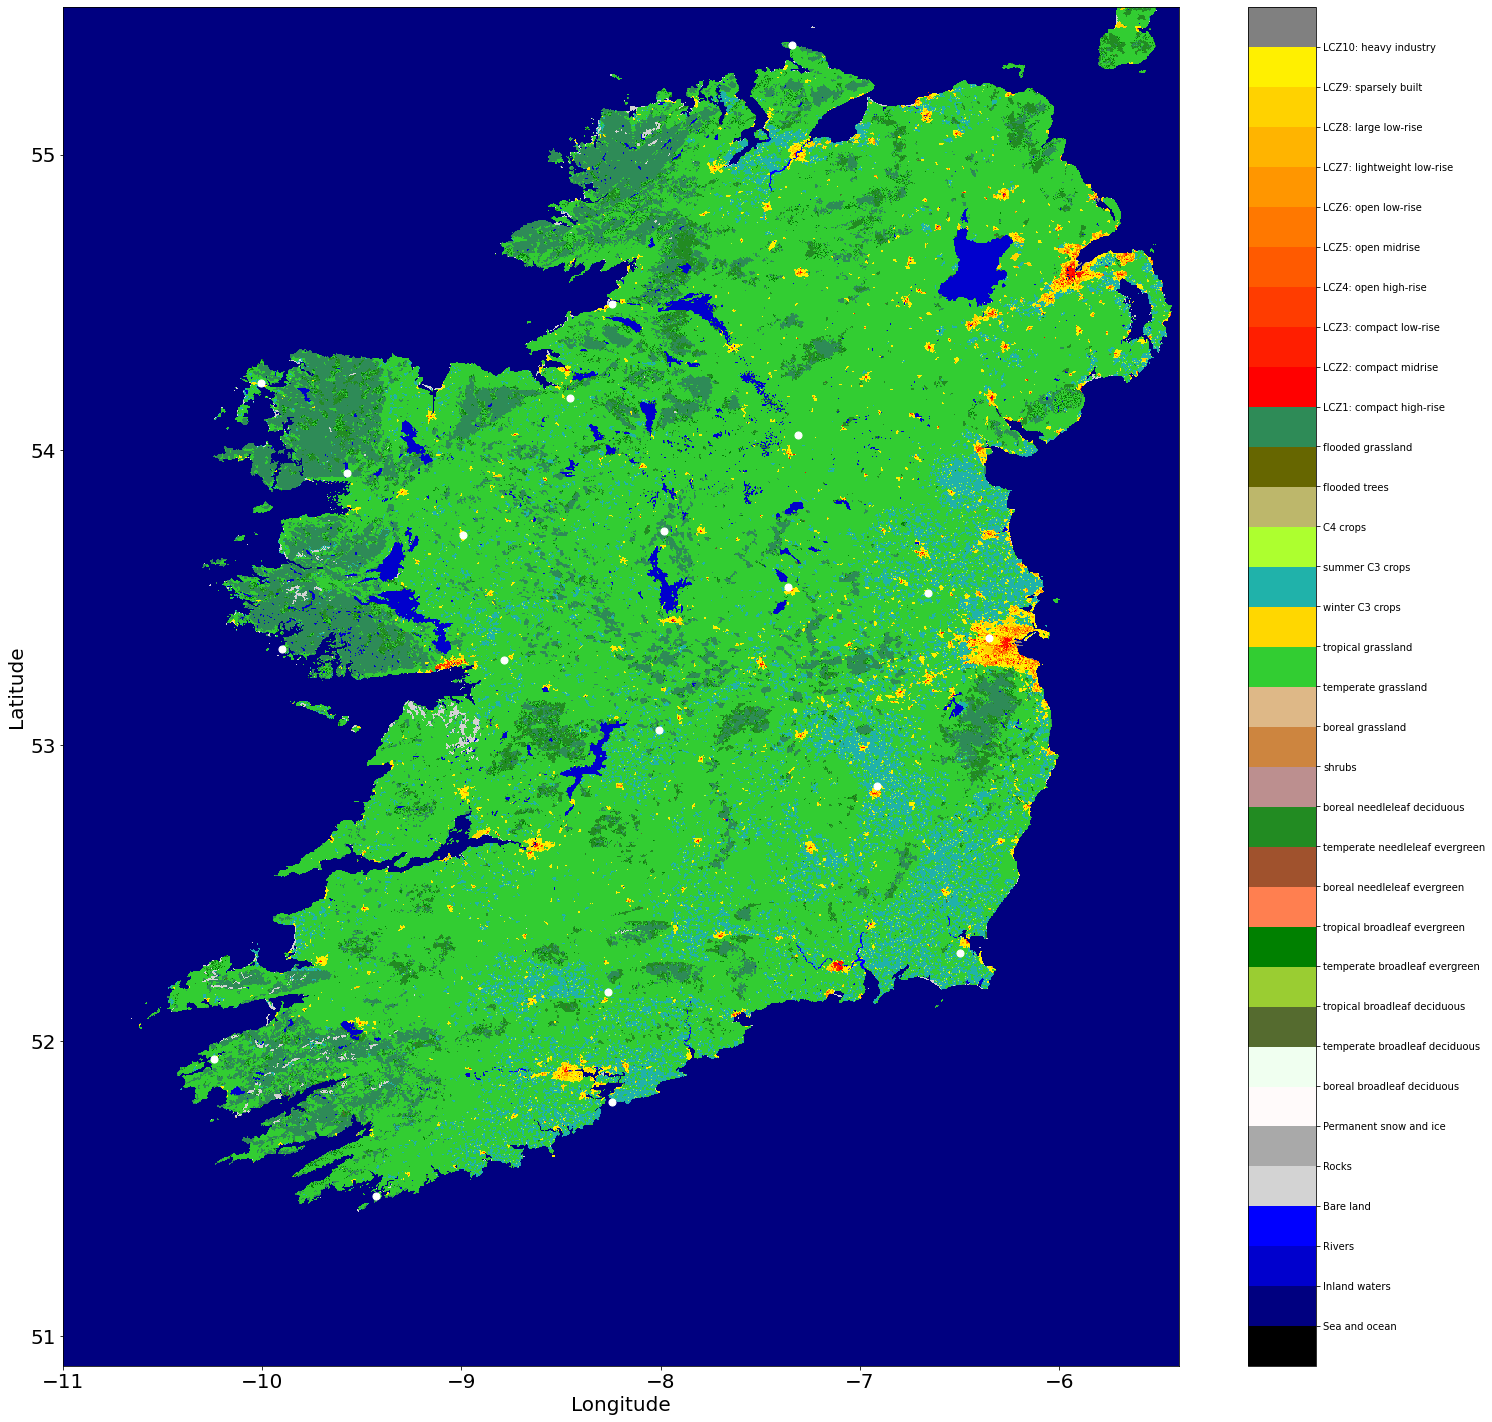

In [28]:
fig = plt.figure(figsize=(25, 25))
ax=fig.gca()
c=ax.pcolormesh(LONSG,LATSG,DSG,cmap=colSG, vmin=np.min(DSG)-1,vmax=np.max(DSG)+1)
sc=ax.scatter(LON,LAT,s=50,c='w')
cb=plt.colorbar(c, ticks=np.arange(np.min(DSG),np.max(DSG)+1),extendfrac='auto', spacing='proportional')
cb.set_ticks([i+1 for i in range(0, len(covername))])  
cb.set_ticklabels(covername)
#cb.ax.tick_params(labelsize=20)
ax.set_xlim(np.min(LONSG),np.max(LONSG))
ax.set_ylim(np.min(LATSG),np.max(LATSG))
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)    

# little domains around station plots

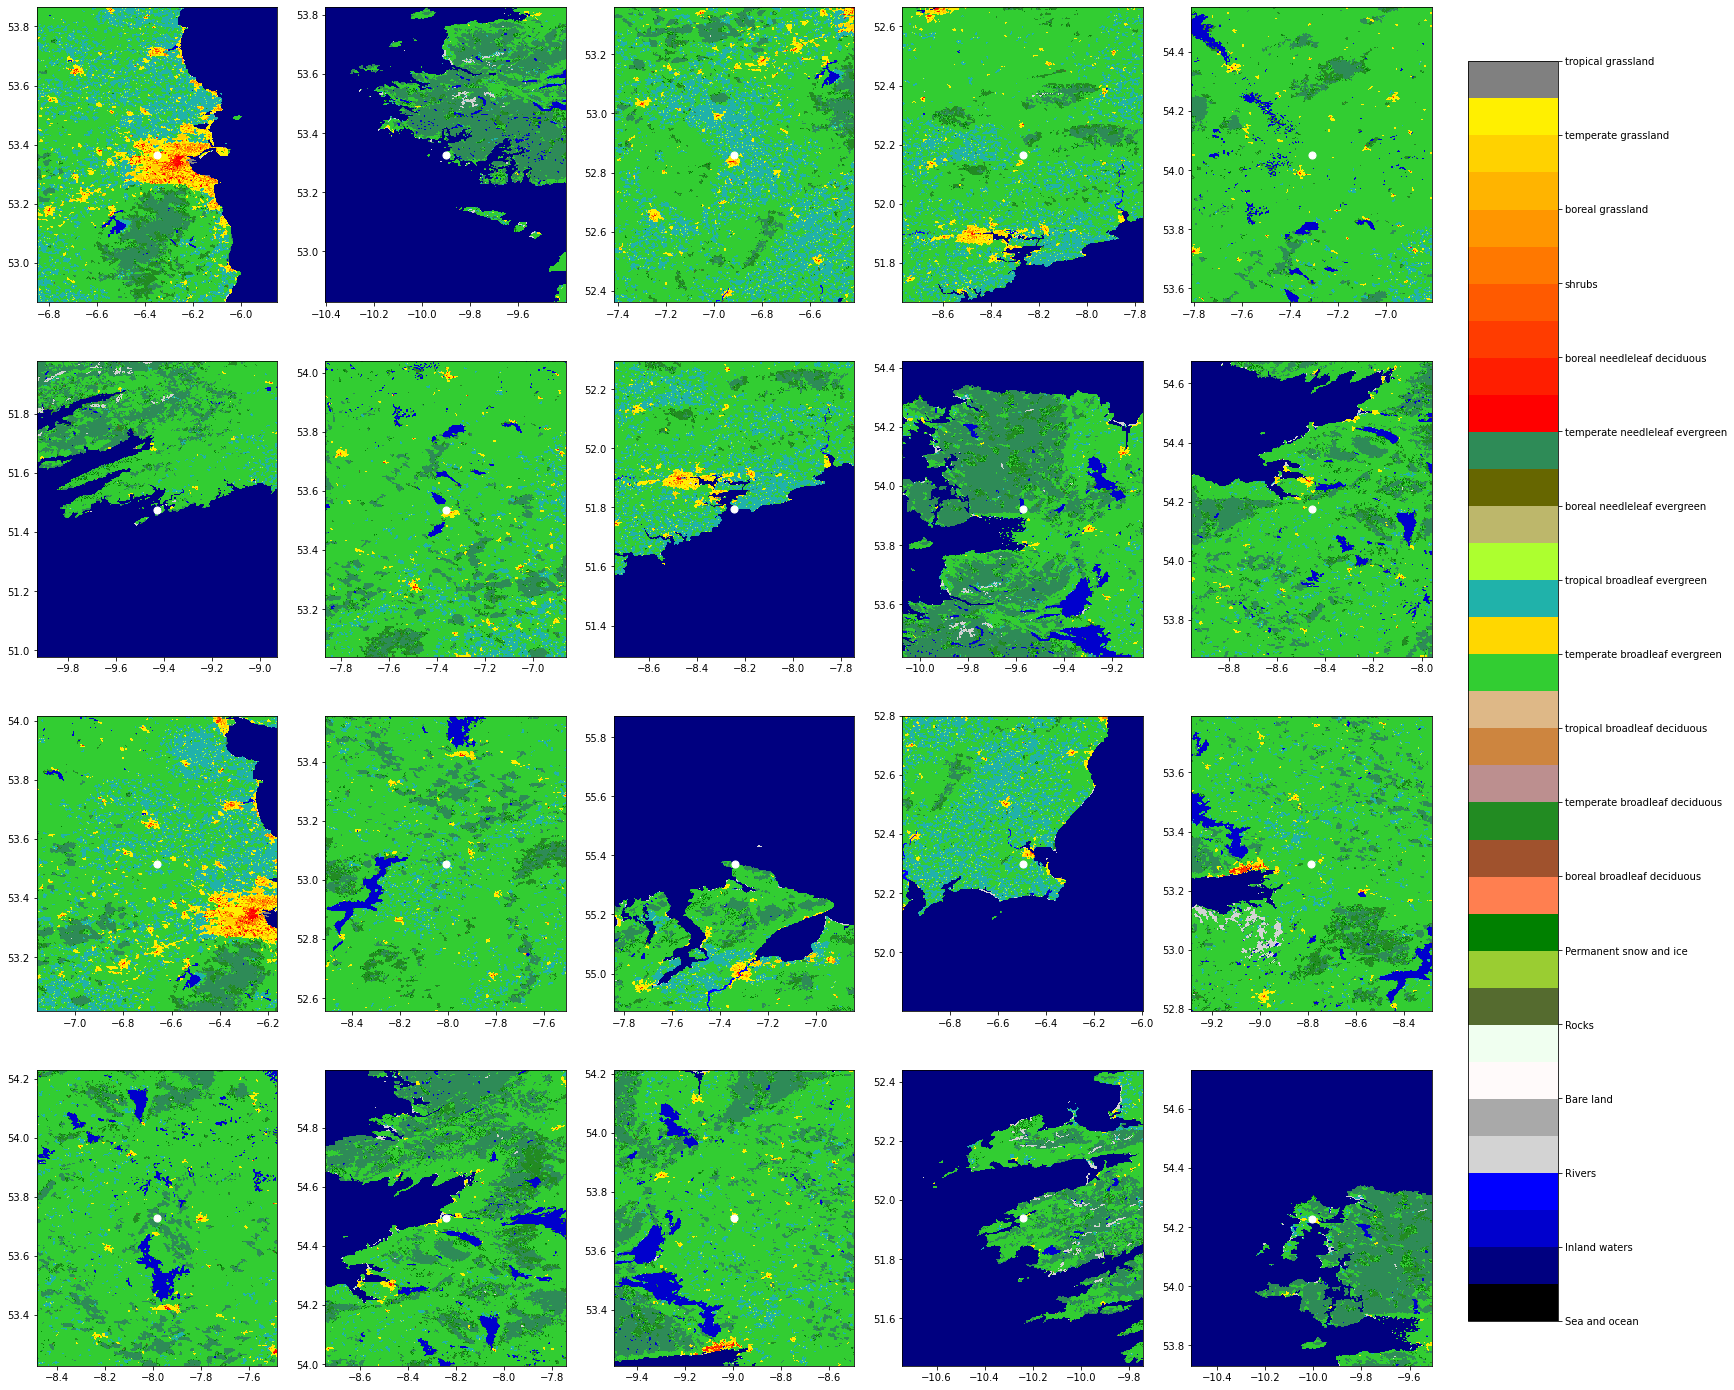

In [52]:
fig, axes = plt.subplots(4, 5,figsize=(25, 25))
for ax,j in zip(axes.ravel(),range(0,len(LAT))):
        latmin=LAT[j]-0.5
        latmax=LAT[j]+0.5
        lonmin=LON[j]-0.5
        lonmax=LON[j]+0.5
        (LATsg,LONsg,Dsg)=get_dataSG(fnameSG,latmax,latmin,lonmax,lonmin)
        c=ax.pcolormesh(LONsg,LATsg,Dsg,cmap=colSG, vmin=np.min(DSG)-1,vmax=np.max(DSG)+1)
        sc=ax.scatter(LON[j],LAT[j],s=50,c='w')
        ax.set_xlim(np.min(LONsg),np.max(LONsg))
        ax.set_ylim(np.min(LATsg),np.max(LATsg))        
        #ax.set_xlabel('Longitude',fontsize=20)
        #ax.set_ylabel('Latitude',fontsize=20)
cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
cb=fig.colorbar(c, cax=cbar_ax, ticks=np.arange(np.min(DSG),np.max(DSG)),extendfrac='auto', spacing='proportional')   
cb.set_ticks([i for i in np.arange(0, 2*len(covername)+1,2)]) 
cb.set_ticklabels(covername)